<center>
<h1> Linear Regression Case Study
</center>

### Steps for Regression Modeling:
1. Business problem definition - One of major automobile company would like to design new product which can improve the sales. Inorder to define the product, they want to understand/identify drivers for the sales (what are the factors driving sales) and Predicting sales of different car models given driving factors. 
2. Convert business problem into statistical problem  sales = F(sales attributes, product features, marketing info etc.)
3. Finding the right technique - Since it is predicting value (Regression Problem) problem so we can use OLS as one of the technique. We can also use other techniques like Decision Trees, Ensemble learning, KNN, SVM, ANN etc.
4. Data colletion(Y, X) - Identify the sources of information and collect the data
5. Consolidate the data - aggregate and consolidate the data at Model level/customer level/store level depends on business problem
6. Data preparation for modeling (create data audit report to identify the steps to perform as part of data preparation)
    a. missing value treatment
    b. outlier treatment
    c. dummy variable creation
7. Variable creation by using transformation and derived variable creation.
8. Basic assumptions (Normality, linearity, no outliers, homoscadasticity, no pattern in residuals, no auto correlation etc)
9. Variable reduction techniques (removing multicollinerity with the help of FA/PCA, correlation matrics, VIF)
10. Create dev and validation data sets (50:50 if you have more data else 70:30 or 80:20)
11. Modeling on dev data set (identify significant variables, model interpretation, check the signs and coefficients, multi-collinierity check, measures of good neess fit, final mathematical equation etc)
12. validating on validation data set (check the stability of model, scoring, decile analysis, cross validation etc.)
13. Output interpretation and derive insights (understand the limitations of the model and define strategy to implementation)
14. convert statistical solution into business solutions (implementation, model monitoring etc)


### import the packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

In [27]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# from sklearn.linear_model import LinearRegression
# sklearn - scikit learn

### create UDFs

In [28]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [29]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100 / x.count(), 2)], 
                     
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [30]:
# Missing value imputation for continuous variables
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [31]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### import data

In [32]:
cars = pd.read_csv('G:\DS\AnalytixLAB\Workbook\dataScienceUsingPython\Class 21 Python for Data Science (Self-paced) v4\Car_sales - 1629042283129.csv')

### data inspection

In [33]:
.columns
.dtypes
.shape

.info()
.describe()
.head()
.tail()

SyntaxError: invalid syntax (101143919.py, line 1)

In [35]:
cars.columns

Index(['Manufacturer', 'Model', 'Sales_in_thousands', 'four_year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [36]:
cars.shape

(157, 16)

In [37]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [38]:
cars.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [39]:
# no of unique values / cardinality
cars.nunique()

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [40]:
cars.Vehicle_type.value_counts()

Passenger    116
Car           41
Name: Vehicle_type, dtype: int64

In [41]:
# type conversion in case variables are not of proper type : Not required in this data

In [42]:
# in case we have huge data and we dont want to make the copy of the original data 
# we generally go with the option of getting column/variable names for obejat and numeric type

numeric_columns = cars.select_dtypes(include = ['float64', 'int64']).columns
object_columns = cars.select_dtypes(include = ['object']).columns

In [43]:
cars[object_columns].head(2)

,Manufacturer,Model,Vehicle_type,Latest_Launch
0,Acura,Integra,Passenger,2/2/2012
1,Acura,TL,Passenger,6/3/2011


In [44]:
numeric_columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')

In [45]:
# seperate object and numeric variables
cars_conti_vars = cars.loc[:, (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[:, (cars.dtypes == 'object')]

# Simper way of doing:
# cars_conti_vars = cars.select_dtypes(include = ['float64', 'int64'])
# car_sales_cat = cars.select_dtypes(include = ['object'])

In [46]:
# alternate of .describe() for continuous variables
cars_conti_vars.apply( continuous_var_summary ).round(1)

# cars_conti_vars.apply( lambda x: continuous_var_summary(x)).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,157,117,152,31,66,88,78,127,147,55,20,154
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8320.698,2186.83,4245.567,477.5,29008.0,16768.0,11099.4,29225.6,523.594,2800.5,3672.0,11941.756636
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.15,187.34359,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
var,4628.002257,131.180007,205.969949,1.0913,3214.926385,58.389512,11.915419,180.412023,0.397532,15.115932,18.341567,632.153558


In [47]:
# alternate of .describe() for categorical variables
cars_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Manufacturer,157,0,Dodge,11,7.01
Model,157,0,Neon,2,1.27
Vehicle_type,157,0,Passenger,116,73.89
Latest_Launch,157,0,10/5/2012,2,1.27


### outlier treatment

In [48]:
cars_conti_vars.Price_in_thousands.clip( lower = cars_conti_vars.Price_in_thousands.quantile(0.01), 
                                       upper = cars_conti_vars.Price_in_thousands.quantile(0.99) )

0      21.50
1      28.40
2        NaN
3      42.00
4      23.99
       ...  
152    24.40
153    27.50
154    28.80
155    45.50
156    36.00
Name: Price_in_thousands, Length: 157, dtype: float64

In [49]:
cars_conti_vars = cars_conti_vars.apply( lambda x: x.clip(lower = x.quantile(0.01),
                                                         upper = x.quantile(0.99)))

In [50]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,115,150,29,64,87,76,125,145,54,19,152
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
nmiss,0,36,2,1,1,1,1,1,2,1,3,2
perc_miss,0.0,22.929936,1.273885,0.636943,0.636943,0.636943,0.636943,0.636943,1.273885,0.636943,1.910828,1.273885
sum,8025.5292,2180.421,4235.95548,475.81,28910.3,16760.1,11102.45,29223.94,523.77016,2799.9,3660.0,11911.685368
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,11.181335,14.06397,0.982279,52.81647,7.424295,3.390339,13.12035,0.621764,3.819854,3.994755,23.844968
var,3331.909938,125.02226,197.795238,0.964871,2789.579526,55.120156,11.4944,172.143594,0.386591,14.591287,15.958068,568.58248


### missing value treatment

In [51]:
cars_conti_vars.isna().sum() * 100 / cars_conti_vars.isna().count()

Sales_in_thousands         0.000000
four_year_resale_value    22.929936
Price_in_thousands         1.273885
Engine_size                0.636943
Horsepower                 0.636943
Wheelbase                  0.636943
Width                      0.636943
Length                     0.636943
Curb_weight                1.273885
Fuel_capacity              0.636943
Fuel_efficiency            1.910828
Power_perf_factor          1.273885
dtype: float64

In [52]:
cars_conti_vars = cars_conti_vars.apply(missing_imputation)

In [53]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,116,151,30,65,88,77,126,146,55,20,153
n_tot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,157,157,157,157,157,157,157,157,157,157,157
nmiss,0,0,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,8025.5292,2829.141298,4290.61297,478.860064,29095.622436,16867.536538,11173.619551,29411.272949,530.528485,2817.848077,3731.298701,12065.384534
mean,51.11802,18.020008,27.328745,3.050064,185.322436,107.436538,71.169551,187.332949,3.379162,17.948077,23.766234,76.849583
std,57.722699,9.80668,13.973525,0.979125,52.646914,7.400461,3.379455,13.07823,0.617766,3.807591,3.956157,23.691622
var,3331.909938,96.170969,195.259402,0.958686,2771.697606,54.766822,11.420718,171.04011,0.381634,14.497753,15.651182,561.292961


## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [54]:
cars_cat_vars.columns

Index(['Manufacturer', 'Model', 'Vehicle_type', 'Latest_Launch'], dtype='object')

In [55]:
cars_cat_vars.Vehicle_type.nunique()

2

In [56]:
# get the count of all the categories of the variable
cars_cat_vars.Manufacturer.value_counts()

Dodge         11
Ford          11
Toyota         9
Chevrolet      9
Mercedes-B     9
Mitsubishi     7
Nissan         7
Chrysler       7
Volvo          6
Oldsmobile     6
Lexus          6
Mercury        6
Pontiac        6
Volkswagen     6
Saturn         5
Cadillac       5
Honda          5
Plymouth       4
Acura          4
Buick          4
Audi           3
Jeep           3
Porsche        3
Hyundai        3
BMW            3
Lincoln        3
Saab           2
Subaru         2
Jaguar         1
Infiniti       1
Name: Manufacturer, dtype: int64

In [57]:
cars_cat_vars.Vehicle_type.value_counts()

Passenger    116
Car           41
Name: Vehicle_type, dtype: int64

**in case we have categorical featue as numeric type, we have to first convert the variable into 
category type**

In [58]:
# get the useful categorical variables
cars_cat_vars = cars.loc[:, ['Manufacturer', 'Vehicle_type']]

# for c_feature in categorical_features
for c_feature in cars_cat_vars.columns:
    
    # cars_cat_vars.loc[:, c_feature] = cars_cat_vars[c_feature].astype('category') # you can skip this step for this example; required for the numeric variables
    cars_cat_vars = create_dummies(cars_cat_vars, c_feature)
    
# see the data in the output
#cars_cat_vars

##### all the variable names should follow the INC rules going further

In [59]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

In [60]:
len(cars_cat_vars.columns)

30

In [61]:
cars_cat_vars.rename( columns = {'Manufacturer_Mercedes-B' : 'Manufacturer_Mercedes_B'}, 
                      inplace = True)

In [62]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

### final data for analysis

In [63]:
cars_conti_vars.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')

In [64]:
cars_cat_vars.columns

Index(['Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger'],
      dtype='object')

##### combine the data ( continuous and categorical ) for further processing

In [65]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)

In [66]:
cars_new.shape

(157, 42)

In [67]:
cars_new.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


In [68]:
cars_new.shape

(157, 42)

### assumptions check

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


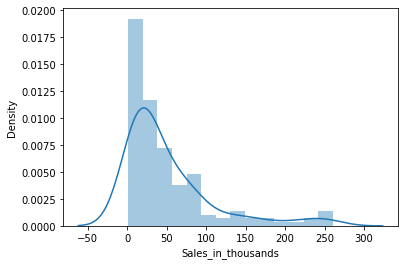

In [69]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.distplot(cars_new.Sales_in_thousands)
plt.show()
# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

In [70]:
cars_new.Sales_in_thousands.skew()

1.9924932920508793

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


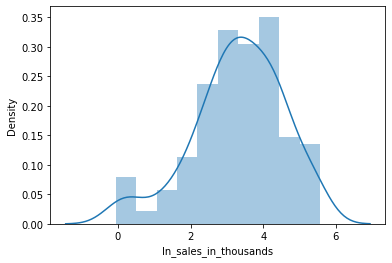

In [71]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In thios data its not required as sales are always greater than zero

# apply log transformation: log is rescalling the data and making the distribution normal
cars_new.loc[:, 'ln_sales_in_thousands'] = np.log(cars_new.loc[:, 'Sales_in_thousands'])

# Distribution of variables
sns.distplot(cars_new.ln_sales_in_thousands)
plt.show()

In [72]:
cars_new.ln_sales_in_thousands.skew()

-0.5925861100519006

In [73]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = cars_new.corr()
corrm.to_excel('D:/corrm.xlsx')
corrm

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,ln_sales_in_thousands
Sales_in_thousands,1.000000,-3.075381e-01,-0.361572,-0.014342,-0.259311,0.278280,0.093054,0.200997,-0.035282,0.044446,...,0.036853,-0.114192,-7.988584e-02,-0.054683,-2.181588e-02,0.133404,-0.056294,-1.333610e-01,-0.230252,0.799513
four_year_resale_value,-0.307538,1.000000e+00,0.832320,0.440258,0.679605,-0.037624,0.158211,0.025517,0.304378,0.284274,...,-0.071303,0.512245,4.121642e-17,-0.087128,5.444000e-17,-0.030552,-0.062450,2.124397e-16,0.076638,-0.479350
Price_in_thousands,-0.361572,8.323203e-01,1.000000,0.618230,0.849851,0.118080,0.328107,0.158161,0.527230,0.430942,...,-0.062676,0.352160,1.860392e-02,-0.170025,-4.839044e-02,-0.094643,-0.137820,5.158511e-02,0.042006,-0.578170
Engine_size,-0.014342,4.402582e-01,0.618230,1.000000,0.815010,0.518423,0.702618,0.576386,0.793937,0.698341,...,0.078278,0.016675,-1.047543e-01,-0.191415,-6.401942e-02,-0.108099,-0.221271,-1.531916e-01,-0.279272,-0.120983
Horsepower,-0.259311,6.796053e-01,0.849851,0.815010,1.000000,0.325247,0.538115,0.420472,0.637823,0.526554,...,-0.001225,0.231413,-1.693190e-02,-0.227139,-4.398854e-02,-0.115857,-0.244956,-1.198690e-02,-0.011910,-0.400528
Wheelbase,0.278280,-3.762379e-02,0.118080,0.518423,0.325247,1.000000,0.681402,0.837566,0.657133,0.659706,...,0.046301,-0.260846,-4.521823e-02,-0.083508,-9.218360e-02,-0.094079,-0.203652,-8.565596e-02,-0.383084,0.270203
Width,0.093054,1.582115e-01,0.328107,0.702618,0.538115,0.681402,1.000000,0.700153,0.710589,0.648557,...,0.042237,-0.060887,-7.315767e-02,-0.200799,-1.102499e-01,-0.115710,-0.187554,-9.484845e-02,-0.241472,0.038309
Length,0.200997,2.551744e-02,0.158161,0.576386,0.420472,0.837566,0.700153,1.000000,0.622789,0.561884,...,0.096592,-0.149884,-1.422854e-02,-0.061395,-5.953822e-02,-0.103610,-0.304533,-5.911793e-02,-0.129701,0.207226
Curb_weight,-0.035282,3.043781e-01,0.527230,0.793937,0.637823,0.657133,0.710589,0.622789,1.000000,0.868131,...,0.007662,-0.094627,-4.503929e-02,-0.221474,-2.013658e-02,-0.070768,-0.161960,-3.058882e-02,-0.519405,-0.051904
Fuel_capacity,0.044446,2.842737e-01,0.430942,0.698341,0.526554,0.659706,0.648557,0.561884,0.868131,1.000000,...,-0.001650,-0.034864,-7.424594e-03,-0.260342,-4.633177e-02,-0.011787,-0.170589,-6.026328e-03,-0.594758,-0.019549


<AxesSubplot:>

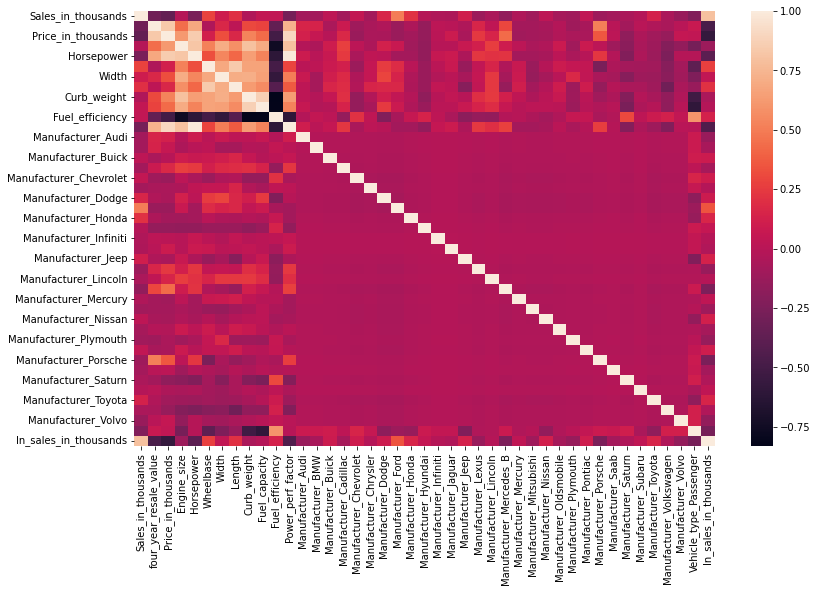

In [74]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (13, 8))
sns.heatmap(cars_new.corr())

# fuel efficiency vs fuel capacity
# Curb weight vs Engine Size

# in case we can't make any concrete decision looking at the variables;
# we can also check on the VAR of the variables into consideration e.g Curb weight vs Wheel base

In [75]:
# no of variables and obs in the final data to be used for modelling
cars_new.shape

(157, 43)

### feature selection based on importance using F - Regression

In [80]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression

In [77]:
# splitting the data: separate out the feature/input/independant columns and dependant variable
feature_columns = cars_new.columns.difference(['ln_sales_in_thousands', 'Sales_in_thousands'])
feature_columns

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

In [78]:
len(feature_columns)

41

In [81]:
# seperate the X and y columns
features = cars_new[ feature_columns ]
target = cars_new.ln_sales_in_thousands

# do the f_regression
F_values, p_values  = f_regression( features, target )

In [82]:
pd.concat( [ pd.Series(feature_columns), pd.Series(F_values).round(2), 
                        pd.Series(p_values).round(4) ], axis = 1 ).head(2)

,0,1,2
0,Curb_weight,0.42,0.5185
1,Engine_size,2.30,0.1312


In [83]:
pd.DataFrame([feature_columns, F_values.round(2), p_values.round(4)]).T.head(2)

,0,1,2
0,Curb_weight,0.42,0.5185
1,Engine_size,2.3,0.1312


In [84]:
# combine the output in dataframe
F_regression_op = pd.DataFrame([feature_columns, F_values.round(2), p_values.round(4)]).T

# add the column names
F_regression_op.columns = ['Features', 'F_values', 'p_values' ]

In [85]:
# output of the f_regression
feature_columns = list( F_regression_op.loc[ F_regression_op.p_values <= 0.1, 'Features' ] )

####  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [86]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [87]:
feature_columns

['Fuel_efficiency',
 'Horsepower',
 'Length',
 'Manufacturer_Audi',
 'Manufacturer_Ford',
 'Manufacturer_Honda',
 'Manufacturer_Mercedes_B',
 'Manufacturer_Plymouth',
 'Manufacturer_Porsche',
 'Manufacturer_Toyota',
 'Manufacturer_Volvo',
 'Power_perf_factor',
 'Price_in_thousands',
 'Vehicle_type_Passenger',
 'Wheelbase',
 'four_year_resale_value']

In [88]:
model_param = 'ln_sales_in_thousands ~ ' + ' + '.join(feature_columns)
model_param

'ln_sales_in_thousands ~ Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Mercedes_B + Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + four_year_resale_value'

In [89]:
model_param = '''ln_sales_in_thousands ~ Fuel_efficiency + Length + 
        Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Mercedes_B + 
        Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + 
        Manufacturer_Volvo + Price_in_thousands + Vehicle_type_Passenger'''

In [90]:
# separate the Y and X variables
y, X = dmatrices( model_param, cars_new, return_type = 'dataframe' )

#### if we go by books VIF more than 10 is not acceptable; but practically we are go with the variables with VIF > 4

we will keep the variables with VIF <= 4

In [91]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF Factor'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,568.6
1,Fuel_efficiency,4.0
2,Length,1.4
3,Manufacturer_Audi,1.1
4,Manufacturer_Ford,1.1
5,Manufacturer_Honda,1.1
6,Manufacturer_Mercedes_B,1.6
7,Manufacturer_Plymouth,1.0
8,Manufacturer_Porsche,1.4
9,Manufacturer_Toyota,1.2


In [92]:
# output of the VIF
feature_columns = list( set(vif.loc[:, 'Features']).difference(['Intercept']) )

In [93]:
feature_columns

['Length',
 'Manufacturer_Volvo',
 'Vehicle_type_Passenger',
 'Manufacturer_Ford',
 'Manufacturer_Audi',
 'Manufacturer_Mercedes_B',
 'Price_in_thousands',
 'Manufacturer_Plymouth',
 'Fuel_efficiency',
 'Manufacturer_Honda',
 'Manufacturer_Porsche',
 'Manufacturer_Toyota']

### split the data for model building

In [94]:
np.random.randint( 10, 100, 10 )

array([98, 97, 33, 52, 50, 94, 41, 37, 76, 77])

In [95]:
feature_columns = ['Fuel_efficiency', 'Length', 'Price_in_thousands', 
                   'Vehicle_type_Passenger', 'Manufacturer_Ford']

In [96]:
# tuple unpacking
a, b = 10, 20

In [97]:
# method 1: divide the data into training and testing
train, test = train_test_split(cars_new, test_size = 0.3, random_state = 12345 )

In [98]:
# method 2: divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related methods
train_X, test_X, train_y, test_y = train_test_split( cars_new[feature_columns], 
                        cars_new['ln_sales_in_thousands'], test_size = 0.3, random_state = 12345)

In [99]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  109  |  No of obs in testing:  48


## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

### building a linear regression model

## model 0

In [100]:
'a ~ ' + 'b + c + d + e'

'a ~ b + c + d + e'

In [101]:
feature_columns

['Fuel_efficiency',
 'Length',
 'Price_in_thousands',
 'Vehicle_type_Passenger',
 'Manufacturer_Ford']

In [102]:
# manual method of defining the model equation
m1_equation = '''ln_sales_in_thousands ~ Fuel_efficiency + Length + Price_in_thousands + 
            Vehicle_type_Passenger + Manufacturer_Ford'''

In [103]:
# preferred method of defining the model equation
m1_equation = 'ln_sales_in_thousands ~ ' + ' + '.join(feature_columns)

In [104]:
lm0 = smf.ols( m1_equation, train ).fit()

In [105]:
print(lm0.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.526
Model:                               OLS   Adj. R-squared:                  0.503
Method:                    Least Squares   F-statistic:                     22.83
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):           2.33e-15
Time:                           13:40:56   Log-Likelihood:                -139.86
No. Observations:                    109   AIC:                             291.7
Df Residuals:                        103   BIC:                             307.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Model 1

In [106]:
cars_new.shape

(157, 43)

In [107]:
cars_new.columns.difference( [ 'Sales_in_thousands', 'ln_sales_in_thousands' ] )

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

In [108]:
model_eq2 = 'ln_sales_in_thousands ~ ' + ' + '.join( cars_new.columns.difference( [ 'Sales_in_thousands', 'ln_sales_in_thousands' ] ) )

In [109]:
model_eq2

'ln_sales_in_thousands ~ Curb_weight + Engine_size + Fuel_capacity + Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_BMW + Manufacturer_Buick + Manufacturer_Cadillac + Manufacturer_Chevrolet + Manufacturer_Chrysler + Manufacturer_Dodge + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Hyundai + Manufacturer_Infiniti + Manufacturer_Jaguar + Manufacturer_Jeep + Manufacturer_Lexus + Manufacturer_Lincoln + Manufacturer_Mercedes_B + Manufacturer_Mercury + Manufacturer_Mitsubishi + Manufacturer_Nissan + Manufacturer_Oldsmobile + Manufacturer_Plymouth + Manufacturer_Pontiac + Manufacturer_Porsche + Manufacturer_Saab + Manufacturer_Saturn + Manufacturer_Subaru + Manufacturer_Toyota + Manufacturer_Volkswagen + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + Width + four_year_resale_value'

In [110]:
lm1 = smf.ols( formula = model_eq2, data = cars_new ).fit()

In [111]:
print( lm1.summary() )

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.707
Model:                               OLS   Adj. R-squared:                  0.603
Method:                    Least Squares   F-statistic:                     6.777
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):           2.47e-16
Time:                           13:58:09   Log-Likelihood:                -162.17
No. Observations:                    157   AIC:                             408.3
Df Residuals:                        115   BIC:                             536.7
Df Model:                             41                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### Model 2

In [113]:
feature_columns

['Fuel_efficiency',
 'Length',
 'Price_in_thousands',
 'Vehicle_type_Passenger',
 'Manufacturer_Ford']

In [114]:
model_eq3 = 'ln_sales_in_thousands ~ ' + ' + '.join( feature_columns )

In [115]:
model_eq3 = '''ln_sales_in_thousands ~ Length + 
            Fuel_efficiency + Vehicle_type_Passenger + Manufacturer_Ford + 
            Price_in_thousands'''

In [116]:
lm2 = smf.ols( model_eq3, train ).fit()

In [117]:
print( lm2.summary() )

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.526
Model:                               OLS   Adj. R-squared:                  0.503
Method:                    Least Squares   F-statistic:                     22.83
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):           2.33e-15
Time:                           13:58:41   Log-Likelihood:                -139.86
No. Observations:                    109   AIC:                             291.7
Df Residuals:                        103   BIC:                             307.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Step 4: predict the sales on the training and testing data

In [118]:
# training
train.loc[:, 'pred_sales'] = np.exp( lm2.predict(train) )

In [119]:
# testing/validation
test.loc[:, 'pred_sales'] = np.exp(lm2.predict(test))

In [120]:
train[['Sales_in_thousands', 'pred_sales']].mean()

Sales_in_thousands    51.427006
pred_sales            39.738783
dtype: float64

In [121]:
train[['Sales_in_thousands', 'pred_sales']].head(2)

,Sales_in_thousands,pred_sales
54,125.33800,113.777806
52,260.64532,110.204074


#### MSE - mean squared error

In [122]:
MSE_train = round( mean_squared_error( train.Sales_in_thousands, train.pred_sales ), 2 )
MSE_test = round( mean_squared_error( test.Sales_in_thousands, test.pred_sales ), 2 )

RMSE_train = round(np.sqrt( MSE_train ), 2)
RMSE_test = round(np.sqrt( MSE_test ), 2)

print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

MSE of training data:  2455.25  |  MSE of testing data:  4302.98
RMSE of training data:  49.55  |  RMSE of testing data:  65.6


#### MAE - mean absolute error

In [123]:
MAE_train = round(mean_absolute_error( train.Sales_in_thousands, train.pred_sales ), 2)
MAE_test = round(mean_absolute_error( test.Sales_in_thousands, test.pred_sales ), 2)

print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  28.89  |  MAE of testing data:  35.96


#### MAPE: Mean Absolute Percentage Error

In [124]:
# accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train.Sales_in_thousands - train.pred_sales)/train.Sales_in_thousands)
MAPE_test = np.mean(np.abs(test.Sales_in_thousands - test.pred_sales)/test.Sales_in_thousands)

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  1.133529625236134  |  MAPE of testing data:  0.7722052476912685


#### corelations

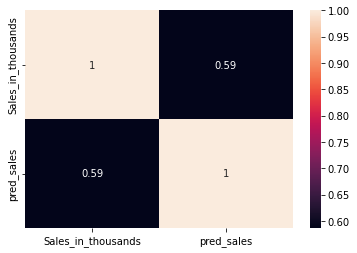

In [125]:
sns.heatmap(train[['Sales_in_thousands', 'pred_sales']].corr(), annot = True)
plt.show()

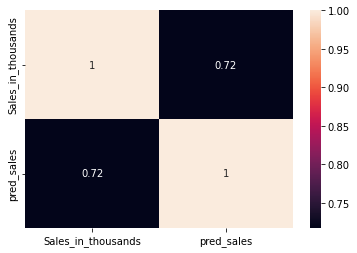

In [126]:
sns.heatmap(test[['Sales_in_thousands', 'pred_sales']].corr(), annot = True)
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


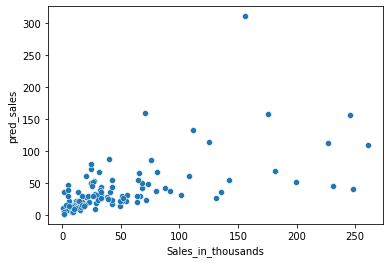

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


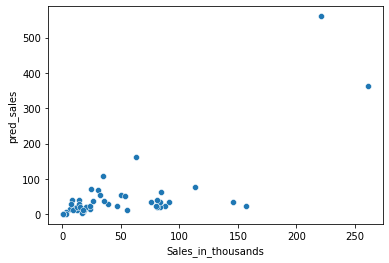

In [127]:
sns.scatterplot( train.Sales_in_thousands, train.pred_sales )
plt.show()
sns.scatterplot( test.Sales_in_thousands, test.pred_sales )
plt.show()

#### Decile Analysis: for validation of models - Business validation

In [128]:
# create the deciles on train and test data
train.loc[:, 'decile'] = pd.qcut( train.pred_sales, 10, labels = False )

test.loc[:, 'decile'] = pd.qcut( test.pred_sales, 10, labels = False )

In [129]:
train.groupby( 'decile' )[['Sales_in_thousands', 'pred_sales']].mean()

,Sales_in_thousands,pred_sales
decile,,
0,5.382364,4.969518
1,15.159844,11.740551
2,22.605091,16.455880
3,28.450636,21.707183
4,47.016636,27.217301
5,43.323800,31.011054
6,69.982273,37.744406
7,72.483182,47.005810
8,71.691545,61.675419


In [130]:
# create the summaries - decile analysis
decile_analysis_train = train.groupby( 'decile' )[['Sales_in_thousands', 
                            'pred_sales']].mean().sort_index( ascending = False).reset_index()
decile_analysis_test = test.groupby( 'decile' )[['Sales_in_thousands', 
                            'pred_sales']].mean().sort_index( ascending = False).reset_index()

In [131]:
decile_analysis_train

,decile,Sales_in_thousands,pred_sales
0,9,137.438029,137.067274
1,8,71.691545,61.675419
2,7,72.483182,47.005810
3,6,69.982273,37.744406
4,5,43.323800,31.011054
5,4,47.016636,27.217301
6,3,28.450636,21.707183
7,2,22.605091,16.455880
8,1,15.159844,11.740551
9,0,5.382364,4.969518


In [132]:
decile_analysis_test

,decile,Sales_in_thousands,pred_sales
0,9,138.627064,254.672958
1,8,44.391800,62.043022
2,7,38.684400,43.162606
3,6,84.836500,35.746035
4,5,44.885200,28.888661
5,4,65.761800,23.713561
6,3,34.845000,20.203901
7,2,27.975200,16.367561
8,1,19.941800,11.091881
9,0,7.984656,2.868208


In [133]:
# write the data into the file
decile_analysis_train.to_csv('Decile_analysis_train.csv')
decile_analysis_test.to_csv('Decile_analysis_test.csv')

#### validate the poor model performance due of LM assumptions

In [134]:
lm2.resid

54     0.096767
52     0.860827
141   -0.006303
8     -0.031217
131   -2.186066
         ...   
34     0.272365
101   -0.026453
126    0.176044
129    0.180532
29     0.225787
Length: 109, dtype: float64

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


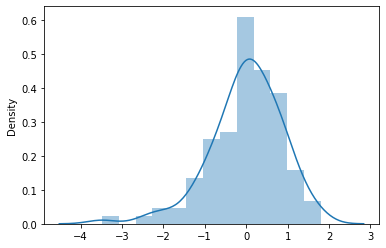

In [135]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm2.resid)
plt.show()

In [136]:
# assumption: mean of residuals/errors is zero
print(lm2.resid.mean())

1.8119043472529274e-14


In [137]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm2.resid, train.ln_sales_in_thousands))

PearsonRResult(statistic=0.6886799858071827, pvalue=1.2713487518661786e-16)


C:\Users\HP\AppData\Local\Temp\ipykernel_17572\1456198128.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  print(stats.stats.pearsonr(lm2.resid, train.ln_sales_in_thousands))


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


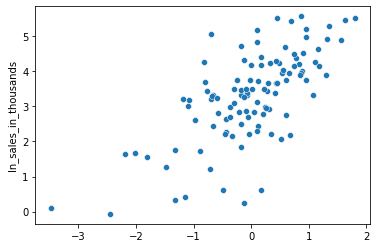

In [138]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm2.resid, train.ln_sales_in_thousands)
plt.show()

#### What can be the possible reasons for poor model performance?

### Tips/guidlines for imporvement of model accuracy

### Other Reading information

### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

### Evaluating Model Accuracy
> R-squared is a statistical measure of how close the data are to the fitted regression line. <br>
> R-square signifies percentage of variations in the reponse variable that can be explained by the model. <br>
> - R-squared = Explained variation / Total variation <br>
> - Total variation is variation of response variable around it's mean. <br>

> R-squared value varies between 0 and 100%. 0% signifies that the model explains none of the variability, <br>
while 100% signifies that the model explains all the variability of the response. <br>
The closer the r-square to 100%, the better is the model. <br>

## Other Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions